# ActivityNet Challenge Proposal Task
This notebook is intended as demo on how to format and evaluate the performance of a submission file for the proposal task. Additionally, a helper function is given to visualize the performance on the evaluation metric.

In [1]:
import sys
sys.path.append('../Evaluation')
from eval_proposal import ANETproposal

import matplotlib.pyplot as plt
import numpy as np
import json

%matplotlib inline

## Help functions to evaluate a proposal submission file and plot the metric results

In [2]:
def run_evaluation(ground_truth_filename, proposal_filename, 
                   max_avg_nr_proposals=100, 
                   tiou_thresholds=np.linspace(0.5, 0.95, 10),
                   subset='validation'):

    anet_proposal = ANETproposal(ground_truth_filename, proposal_filename,
                                 tiou_thresholds=tiou_thresholds,
                                 max_avg_nr_proposals=max_avg_nr_proposals,
                                 subset=subset, verbose=True, check_status=True)
    anet_proposal.evaluate()
    
    recall = anet_proposal.recall
    average_recall = anet_proposal.avg_recall
    average_nr_proposals = anet_proposal.proposals_per_video
    
    return (average_nr_proposals, average_recall, recall)

def plot_metric(average_nr_proposals, average_recall, recall, tiou_thresholds=np.linspace(0.5, 0.95, 10)):

    fn_size = 14
    plt.figure(num=None, figsize=(6, 5))
    ax = plt.subplot(1,1,1)
    
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    area_under_curve = np.zeros_like(tiou_thresholds)
    for i in range(recall.shape[0]):
        area_under_curve[i] = np.trapz(recall[i], average_nr_proposals)

    for idx, tiou in enumerate(tiou_thresholds[::2]):
        ax.plot(average_nr_proposals, recall[2*idx,:], color=colors[idx+1],
                label="tiou=[" + str(tiou) + "], area=" + str(int(area_under_curve[2*idx]*100)/100.), 
                linewidth=4, linestyle='--', marker=None)

    # Plots Average Recall vs Average number of proposals.
    ax.plot(average_nr_proposals, average_recall, color=colors[0],
            label="tiou = 0.5:0.05:0.95," + " area=" + str(int(np.trapz(average_recall, average_nr_proposals)*100)/100.), 
            linewidth=4, linestyle='-', marker=None)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[-1]] + handles[:-1], [labels[-1]] + labels[:-1], loc='best')
    
    plt.ylabel('Average Recall', fontsize=fn_size)
    plt.xlabel('Average Number of Proposals per Video', fontsize=fn_size)
    plt.grid(b=True, which="both")
    plt.ylim([0, 1.0])
    plt.setp(plt.axes().get_xticklabels(), fontsize=fn_size)
    plt.setp(plt.axes().get_yticklabels(), fontsize=fn_size)

    plt.show()


## Generate uniform random proposal for the validation subset

In [3]:
%%time

# seed the random number generator to get consistent results across multiple runs 
np.random.seed(42)

with open("../Evaluation/data/activity_net.v1-3.min.json", 'r') as fobj:
    gd_data = json.load(fobj)

subset='validation'
avg_nr_proposals = 100
proposal_data = {'results': {}, 'version': gd_data['version'], 'external_data': {}}

for vid_id, info in gd_data['database'].iteritems():
    if subset != info['subset']:
        continue
    this_vid_proposals = []
    for _ in range(avg_nr_proposals):
        # generate random proposal center, length, and score
        center = info['duration']*np.random.rand(1)[0]
        length = info['duration']*np.random.rand(1)[0]
        proposal = {
                    'score': np.random.rand(1)[0],
                    'segment': [center - length/2., center + length/2.],
                   }
        this_vid_proposals += [proposal]
    
    proposal_data['results'][vid_id] = this_vid_proposals

with open("../Evaluation/data/uniform_random_proposals.json", 'w') as fobj:
    json.dump(proposal_data, fobj)


CPU times: user 12.5 s, sys: 344 ms, total: 12.9 s
Wall time: 12.9 s


## Evaluate the uniform random proposals and plot the metric results

[INIT] Loaded annotations from validation subset.
	Number of ground truth instances: 7271
	Number of proposals: 471000
	Fixed threshold for tiou score: [ 0.5   0.55  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95]
[RESULTS] Performance on ActivityNet proposal task.
	Area Under the AR vs AN curve: 44.8843969193%


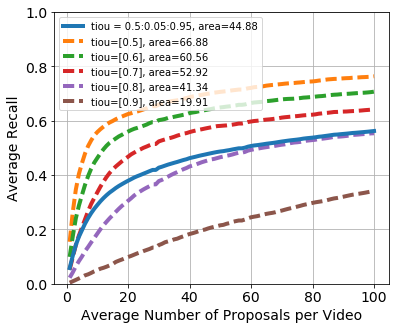

CPU times: user 36.3 s, sys: 2.06 s, total: 38.4 s
Wall time: 37 s


In [4]:
%%time

uniform_average_nr_proposals_valid, uniform_average_recall_valid, uniform_recall_valid = run_evaluation(
    "../Evaluation/data/activity_net.v1-3.min.json",
    "../Evaluation/data/uniform_random_proposals.json",
    max_avg_nr_proposals=100,
    tiou_thresholds=np.linspace(0.5, 0.95, 10),
    subset='validation')

plot_metric(uniform_average_nr_proposals_valid, uniform_average_recall_valid, uniform_recall_valid)
